## Step 1 -- downloading data from TK's folder, imageStack

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [2]:
import os, sys
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

In [3]:
folderName = '//dm11/ahrenslab/Takashi/toZiqiang/02212018Fish2-1/'

### Camera infomation

In [4]:
from utils import getCameraInfo
cameraInfo = getCameraInfo.getCameraInfo(folderName)

In [5]:
pixel_x0, pixel_x1, pixel_y0, pixel_y1 = [int(_) for _ in cameraInfo['camera_roi'].split('_')]
pixel_x = (pixel_x0, pixel_x1)
pixel_y = (pixel_y0, pixel_y1)

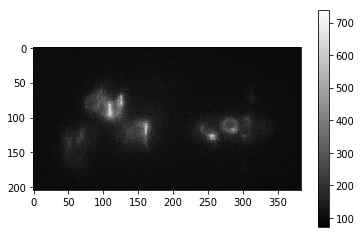

In [6]:
imgFileName = 'Raw_stack.tif'
imgFile = os.path.join(folderName, imgFileName)
imgStack = io.imread(imgFile)
# check the first image
plt.imshow(imgStack[0], cmap='gray')
plt.colorbar()
plt.show()

### Step 2 -- simple denoising

In [7]:
cameraNoiseMat = '//dm11/ahrenslab/Ziqiang/gainMat/gainMat20180208'

In [11]:
offset = np.load(cameraNoiseMat +'/offset_mat.npy')
gain = np.load(cameraNoiseMat +'/gain_mat.npy')
offset_ = offset[pixel_x[0]:pixel_x[1], pixel_y[0]:pixel_y[1]]
gain_ = gain[pixel_x[0]:pixel_x[1], pixel_y[0]:pixel_y[1]]

In [13]:
from pixelwiseDenoising.simpleDenioseTool import simpleDN
imgD_ = simpleDN(imgStack, offset=offset_, gain=gain_)

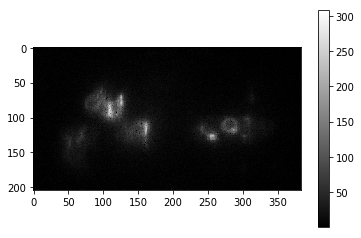

In [14]:
plt.imshow(imgD_[0], cmap='gray')
plt.colorbar()
plt.show()

### Step 3 -- motion detection / image registration

In [ ]:
from imageRegistration.imTrans import ImAffine
trans = ImAffine()

In [ ]:
trans.level_iters = [1000, 1000, 100]
trans.ss_sigma_factor = 1.0
fix = imgD_[0]
move = imgD_[len(imgD_)-1]

### Step 3.1 -- from the first and last frame to decide if motion correction is neccessary

In [ ]:
trans_affine = trans.estimate_rigid2d(fix, move)

### 3.2 -- motion detection (create movie)

In [ ]:
# import caiman as cm
# cm.movie(imgD_).play(gain=3, fr=100, magnification=2)

### 3.3 -- motion correction for both raw and denoised image

In [ ]:
imgStackMotion = imgStack.copy()
imgDMotion = imgD_.copy()

In [ ]:
imgStackMotionVar = np.zeros((len(imgStackMotion), 3)) #phase, dx, dy
imgDMotionVar = np.zeros((len(imgStackMotion), 3))

In [ ]:
fix = imgStack[0]
fix_ = imgD_[0]
for nFrame in range(1, len(imgStack)):
    print(nFrame)
    move = imgStack[nFrame]
    move_ = imgD_[nFrame]
    trans_affine = trans.estimate_rigid2d(fix, move)
    imgStackMotion[nFrame] = trans_affine.transform(move)
    trans_mat = trans_affine.affine
    imgStackMotionVar[nFrame] = np.array([trans_mat[0, 1]/trans_mat[0, 0], trans_mat[0, 2], trans_mat[1, 2]])
    trans_affine = trans.estimate_rigid2d(fix_, move_)
    imgDMotion[nFrame] = trans_affine.transform(move_)
    trans_mat = trans_affine.affine
    imgDMotionVar[nFrame] = np.array([trans_mat[0, 1]/trans_mat[0, 0], trans_mat[0, 2], trans_mat[1, 2]])

In [ ]:
f, ax = plt.subplots(1, 3)
for nplot in range(3):
    ax[nplot].plot(imgStackMotionVar[:, nplot])
    ax[nplot].plot(imgDMotionVar[:, nplot])
plt.show()

In [ ]:
np.save('imgStackMotion', imgStackMotion)
np.save('imgStackMotionVar', imgStackMotionVar)
np.save('imgDMotion', imgDMotion)
np.save('imgDMotionVar', imgDMotionVar)

In [ ]:
imgStackMotion = np.load('imgStackMotion.npy')
imgDMotion = np.load('imgDMotion.npy')

In [ ]:
import caiman as cm
M1 = cm.movie(imgStackMotion)
M2 = cm.movie(imgDMotion)
# M3 = M1.motion_correct()
# M2 = M2 - M2.min(0,keepdims=True)
# M2 = M2 - M2.min(0,keepdims=True)
# movies = [M1,M2]
# max_vals =list(map(np.max,movies))
# max_all = np.max(max_vals)
# M1 = M1*max_all/max_vals[0]
# M2 = M2*max_all/max_vals[1]
# cm_movie = cm.concatenate([M1,M2,M3[0]],axis=2)[:,:,:]
cm_movie = cm.concatenate([M1,M2],axis=2)[:,:,:]
cm_movie.play(gain=3, fr=100, magnification=2)

### Step 4 -- crop a cell

In [ ]:
crop_x = (410, 450)
crop_y = (65, 95)

In [ ]:
mask = np.zeros(fix.shape)
mask[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]] = 1

In [ ]:
plt.imshow(fix)
plt.imshow(mask, alpha=0.8)
plt.show()

### Step 5 -- compute df/f

In [ ]:
cropRaw = imgStackMotion[:, mask==1]
cropSDN = imgDMotion[:, mask==1]

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cropRaw[0].reshape(40, 30))
ax1.set_title('Raw image')
ax1.axis('off')
ax2.imshow(cropSDN[0].reshape(40, 30))
ax2.set_title('Denoised image')
ax2.axis('off')
plt.show()

In [ ]:
plt.plot(cropRaw.mean(axis=1), label='Raw data')
plt.plot(cropSDN.mean(axis=1), label='Denoised data')
plt.ylabel('F (pixel intensity)')
plt.xlabel('Time (frame)')
plt.legend()
plt.show()

In [ ]:
plt.plot(cropRaw.mean(axis=1), cropSDN.mean(axis=1), 'o')
plt.xlabel('Raw data F')
plt.ylabel('Denoised data F')
plt.show()

In [ ]:
def compute_dff(sig):
    bg = np.percentile(sig, 5, axis=1)
    return (sig.mean(axis=1)-sig.mean(axis=1).mean())/(sig.mean(axis=1).mean()-bg)

In [ ]:
dff_raw = compute_dff(cropRaw)
dff_sdn = compute_dff(cropSDN)

In [ ]:
plt.plot(dff_raw, label='Raw data')
plt.plot(dff_sdn, label='Denoised data', alpha=0.5)
plt.ylabel('DF/F (pixel intensity)')
plt.xlabel('Time (frame)')
plt.legend()
plt.show()

In [ ]:
plt.plot(dff_raw, dff_sdn, 'o')
plt.xlabel('Raw data DF/F')
plt.ylabel('Denoised data DF/F')
plt.show()